# Implicit Time Integrator - (WIP / no working yet!)

Implementation of an implicit time integrator.

This is a larger notebook and still working on it
- [ ] add edge normal on Kinematic
- [ ] add collision detection with a proper computation of the contact normal
- [ ] add more formula / explaination / comments
- [ ] replace force and df/fx with energy + newton solver, quasinewton solver


In [1]:
import os
import gdown
import math
import numba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as collections
from matplotlib.collections import LineCollection, PolyCollection
import scipy
import scipy.sparse
import scipy.sparse.linalg

## Download Data

In [2]:
data_root = '_downloaded/geo'
url = 'https://github.com/vincentbonnetcg/Numerical-Bric-a-Brac/raw/master/data/geo/rabbit.npz'
rabbit_path = os.path.join(data_root, 'rabbit.npz')
os.makedirs(data_root, exist_ok=True)
if os.path.exists(rabbit_path)==False:
    gdown.download(url, rabbit_path, quiet=True)

## Helper Functions (Should be moved in the solver)

In [3]:
@numba.njit(inline='always')
def rotation_matrix(rotation):
    theta = np.radians(rotation)
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, -s), (s, c)))

@numba.njit(inline='always')
def norm(v):
    # TODO : is that needed ? 
    dot = (v[0] * v[0]) + (v[1] * v[1])
    return math.sqrt(dot)

@numba.njit(inline='always')
def is_close(v0, v1, tol=1.e-8):
    return math.fabs(v0 - v1) < tol

@numba.njit
def spring_stretch_jacobian(x0, x1, rest, stiffness):
    direction = x0 - x1
    stretch = norm(direction)
    I = np.identity(2)
    if not is_close(stretch, 0.0):
        direction /= stretch
        A = np.outer(direction, direction)
        return -1.0 * stiffness * ((1 - (rest / stretch)) * (I - A) + A)

    return -1.0 * stiffness * I

@numba.njit
def spring_stretch_force(x0, x1, rest, stiffness):
    direction = x1 - x0
    stretch = norm(direction)
    if not is_close(stretch, 0.0):
        direction /= stretch
        
    return direction * ((stretch - rest) * stiffness)

@numba.njit
def elastic_spring_energy(x0, x1, rest, stiffness):
    stretch = distance(x0, x1)
    return 0.5 * stiffness * ((stretch - rest)**2)

## Dynamic

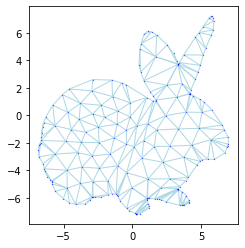

In [4]:
class Dynamic:
    def __init__(self, num_nodes, num_edges):
        self.x = np.zeros((num_nodes, 2))
        self.v = np.zeros((num_nodes, 2))
        self.f = np.zeros((num_nodes, 2))
        self.m = np.zeros((num_nodes, 1))
        self.edges = np.zeros((num_edges, 2), dtype=int)

    def draw_dynamic(self, ax):
        x, y = zip(*self.x)
        ax.plot(x, y, '.', alpha=1.0, color='blue', markersize=0.5)
        collection = LineCollection(self.x[self.edges], linewidths=1.0,
                                    colors='lightblue', linestyles='solid')
        ax.add_collection(collection)

def create_dynamic_from_file(filepath):
    """ Create a dynamic object from filepath
    Args:
        filepath (string) : filepath of the numpy object (*.npz)
    """
    npzfile = np.load(filepath)
    geo_x = npzfile['positions']
    geo_edges = npzfile['edge_vertex_ids']
    num_nodes = geo_x.shape[0]
    num_edges = geo_edges.shape[0]    
    dyn = Dynamic(num_nodes, num_edges)    
    np.copyto(dyn.x, geo_x)
    np.copyto(dyn.edges, geo_edges)
    dyn.m.fill(1.0)
 
    return dyn

def create_chain(num_nodes=10):
    """ Create a chain
    Args: 
        num_nodes (int) : number of nodes in the chain
    """
    num_edges = num_nodes - 1
    y = np.linspace(6, -10, num=num_nodes)
    x = np.ones(num_nodes) * -10
    dyn = Dynamic(num_nodes, num_edges)
    np.copyto(dyn.x, np.stack([x, y], axis=1))
    edges = []
    for i in range(num_edges):
        edges.append((i,i+1))
    np.copyto(dyn.edges, np.asarray(edges))
    dyn.m.fill(1.0)
    
    return dyn

fig, ax = plt.subplots()
ax.set_aspect('equal')
dynamic = create_dynamic_from_file(rabbit_path)
dynamic.draw_dynamic(ax)

## Kinematic

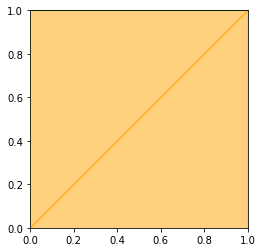

In [5]:
class Kinematic:
    def __init__(self, num_vertices, num_edges, num_faces):
        self.x = np.zeros((num_vertices, 2))
        self.edge_normals = np.zeros((num_edges, 2))
        self.edges = np.zeros((num_edges, 2), dtype=int)
        self.faces = np.zeros((num_faces, 3), dtype=int)

    def transform(self, position, rotation):
        self.x = np.dot(self.x, rotation_matrix(rotation))
        self.x += np.asarray(position)
        # TODO - update edge_normals
        return self

    def draw_kinematic(self, ax):
        collec = PolyCollection(self.x[self.faces], 
                                facecolor='orange',
                                edgecolor='orange',
                                alpha=0.5)
        ax.add_collection(collec)
        collec = LineCollection(self.x[self.edges],
                               linewidths=1,
                               colors='green')
        ax.add_collection(collec)
    
def create_box(width, height):
    kin = Kinematic(num_vertices=4, num_edges=4, num_faces=2)
    min_x, max_x = width * -0.5, width * 0.5
    min_y, max_y = height * -0.5, height * 0.5
    kin.x[:] = ((min_x, min_y), (min_x, max_y), 
                (max_x, max_y), (max_x, min_y))
    kin.edges[:] = ((0, 1),(1,2),(2, 3),(3,0))
    kin.faces[:] = ((0, 1, 2),(0, 2, 3))
    return kin


def combine_kinematic(kinematics):
    """
    Combine multiple kinematics into one kinematic object
    Update the edge and face indices accordingly
    """
    num_vertices = 0
    num_edges = 0
    num_faces = 0
    for kin in kinematics:
        num_vertices += len(kin.x)
        num_edges += len(kin.edges)
        num_faces += len(kin.faces)

    result_kin = Kinematic(num_vertices, num_edges, num_faces)
    offsets = [0,0,0]
    for kin in kinematics:
        result_kin.x[offsets[0]:offsets[0]+len(kin.x)] = kin.x
        result_kin.edges[offsets[1]:offsets[1]+len(kin.edges)] = kin.edges+offsets[0]
        result_kin.faces[offsets[2]:offsets[2]+len(kin.faces)] = kin.faces+offsets[0]
        offsets[0] = offsets[0] + len(kin.x)
        offsets[1] = offsets[1] + len(kin.edges)
        offsets[2] = offsets[2] + len(kin.faces)

    return result_kin  

kinematic_box = create_box(2,2)
fig, ax = plt.subplots()
ax.set_aspect('equal')
kinematic_box.draw_kinematic(ax) 

## Constraint

In [6]:
class Constraint:
    def __init__(self, num_constraints, num_nodes):
        # num_nodes is the number of nodes per constraint
        self.num_nodes = num_nodes
        self.k = None
        self.ids = None
        self.f = None
        self.dfdx = None
        self.initialize(num_constraints)
        
    def initialize(self, num_constraints):
        if (num_constraints <= 0):
            return

        self.k = np.zeros(num_constraints)
        self.ids = np.zeros((num_constraints, self.num_nodes), dtype=int)
        self.f = np.zeros((num_constraints, self.num_nodes, 2)) # forces
        self.dfdx = np.zeros((num_constraints, self.num_nodes, self.num_nodes, 2, 2))

class AnchorConstraint(Constraint):
    def __init__(self, num_constraints):
        Constraint.__init__(self, num_constraints, 1)
        self.anchor_pos = np.zeros((num_constraints, 2))
        self.anchor_rest = np.zeros(num_constraints)

    def evaluate(self, X, V):
        """ compute energy derivatives
        Args:
            X (np.array) : position array
            V (np.array) : velocity array
        """
        num_constraints = self.ids.shape[0]
        for i in range(num_constraints):
            node_id = self.ids[i][0]
            x, v = X[node_id], V[node_id]
            # kinematic velocity
            k_v = np.zeros(2)
            # compute constraint derivatives
            self.f[i][0] = spring_stretch_force(x, self.anchor_pos[i], self.anchor_rest[i], self.k[i])
            self.dfdx[i][0][0] = spring_stretch_jacobian(x, self.anchor_pos[i], self.anchor_rest[i], self.k[i])

class SpringConstraint(Constraint):
    def __init__(self, num_constraints):
        Constraint.__init__(self, num_constraints, 2)
        self.rest = np.zeros(num_constraints)
        
    def evaluate(self, X, V):
        """ compute energy derivatives
        Args:
            X (np.array) : position array
            V (np.array) : velocity array
        """
        num_constraints = self.ids.shape[0]
        for i in range(num_constraints):
            id0, id1 = self.ids[i][0], self.ids[i][1]
            x0, v0 = X[id0], V[id0]
            x1, v1 = X[id1], V[id1]
            # compute constraint force
            force = spring_stretch_force(x0, x1, self.rest[i], self.k[i])
            self.f[i][0] = force 
            self.f[i][1] = force * -1
            # compute jacobians
            dfdx = spring_stretch_jacobian(x0, x1, self.rest[i], self.k[i])
            self.dfdx[i][0][0] = self.dfdx[i][1][1] = dfdx
            self.dfdx[i][0][1] = self.dfdx[i][1][0] = dfdx * -1
    
def create_springs_from_edges(dyn, stiffness):
    # Set spring constraints (internal forces)
    ctn = SpringConstraint(num_constraints=len(dyn.edges))
    ctn.k.fill(stiffness)
    ctn.ids = dyn.edges
    # compute the rest
    for i in range(len(dyn.edges)):
        id0, id1 = ctn.ids[i][0], ctn.ids[i][1]
        x0, x1 = dyn.x[id0], dyn.x[id1]
        ctn.rest[i] = norm(x0 - x1)
    return ctn

## Utility function (Collision) 

In [7]:
@numba.njit
def is_inside_face(face_data, p):
    # face_data shape [3,2]
    # p shape [3]
    x0, x1, x2 = face_data[0], face_data[1], face_data[2]
    v0 = x2 - x0
    v1 = x1 - x0
    v2 = p - x0

    dot00, dot01, dot02 = np.dot(v0, v0), np.dot(v0, v1), np.dot(v0, v2)
    dot11, dot12 = np.dot(v1, v1), np.dot(v1, v2)

    inv = 1.0 / (dot00 * dot11 - dot01 * dot01)
    a = (dot11 * dot02 - dot01 * dot12) * inv
    b = (dot00 * dot12 - dot01 * dot02) * inv
    if a>=0 and b>=0 and a+b<=1:
        return True
    return False

@numba.njit
def is_inside_faces(face_array, pos):
    # face_array shape [num_faces, 3, 2]
    # p shape [3]
    # return the index of the face in collision
    num_faces = len(face_array)
    for i in range(num_faces):
        if is_inside_face(face_array[i], pos):
            return i
    return -1

def get_closest_param(edge_data, pos):
    # edge_array shape [n, 2]
    # p shape [3]
    min_distance2 = 1000 # TODO - update to max 
    closest_point = np.asarray([2,1])
    for x0, x1 in edge_data:
        edge_dir = x1 - x0 # could be precomputed
        edge_dir_square = np.dot(edge_dir, edge_dir)
        proj_p = np.dot(pos - x0, edge_dir)
        t = proj_p / edge_dir_square
        t = max(min(t, 1.0), 0.0)
        projected_point = x0 + edge_dir * t # correct the project point
        vector_distance = (projected_point - pos)
        distance2 = np.dot(vector_distance, vector_distance)
        if distance2 < min_distance2:
            min_distance2 = distance2
            closest_point = projected_point 
    
    return closest_point

## Scene

Finally, the kinematic, dynamic and constraints are combined together into a single scene.

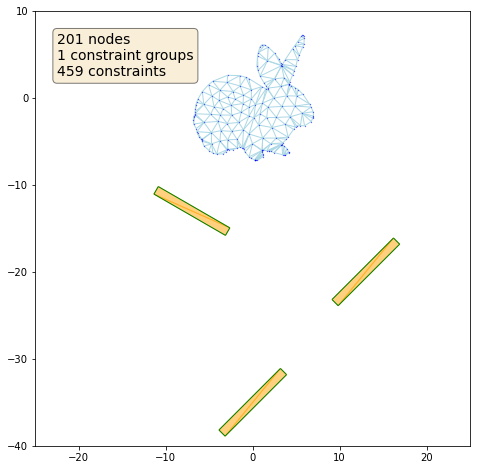

In [9]:
class Scene:
    def __init__(self):
        self.reset()
    
    def reset(self):
        # create colliders
        collider_0 = create_box(9.5,1).transform((-7,-13), 30)
        collider_1 = create_box(10,1).transform((13,-20), -45)
        collider_2 = create_box(10,1).transform((0,-35), -45)
        # set scene
        self.dynamic = create_dynamic_from_file(rabbit_path)
        self.kinematic = combine_kinematic([collider_0,collider_1,collider_2])
        self.static_conditions = [create_springs_from_edges(self.dynamic, 100000)]
        self.step_conditions = []
        self.force = None
    
    @property
    def conditions(self):
        return self.static_conditions + self.step_conditions
    
    def num_nodes(self):
        return len(self.dynamic.x)
    
    def num_constraint_groups(self):
        return len(self.conditions)
    
    def num_constraints(self):
        num_cnts = 0
        for cnd in self.conditions:
            num_cnts += len(cnd.ids)
        return num_cnts
    
    def draw(self, ax):
        ax.clear()
        ax.set_xlim(-25, 25)
        ax.set_ylim(-40, 10)
        ax.margins(0.05)
        ax.set_aspect('equal')
        textstr = '\n'.join((
            f'{self.num_nodes()} nodes',
            f'{self.num_constraint_groups()} constraint groups',
            f'{self.num_constraints()} constraints'))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
        self.kinematic.draw_kinematic(ax)
        self.dynamic.draw_dynamic(ax)
    
fig, ax = plt.subplots(figsize=(8,8))
scene = Scene()
scene.draw(ax)

## Simulation Maths

HERE, explain the mathematics

## Simulation Loop

### Prepare Data

In [10]:
def reset_constraints(scene):
    # reset constraints created per step
    scene.step_conditions = []

def reset_force(scene):
    scene.dynamic.f.fill(0)

def add_gravity(scene, gravity):
    scene.dynamic.f += scene.dynamic.m * gravity

### Assemble System

In [11]:
'''
 Implicit Step
 Solve :
     (M - h * df/dv - h^2 * df/dx) * deltaV = h * (f0 + h * df/dx * v0)
       A = (M - h^2 * df/dx)
       b = h * (f0 + h * df/dx * v0)
     => A * deltaV = b <=> deltaV = A^-1 * b
     deltaX = (v0 + deltaV) * h
     v = v + deltaV
     x = x + deltaX
'''
def assemble_A(scene, h):   
    dyn = scene.dynamic
    num_nodes = dyn.x.shape[0]
    A = np.zeros((num_nodes*2, num_nodes*2))
    
    # Mass matrix 
    mass_diag = np.repeat(dyn.m, 2)
    np.fill_diagonal(A, mass_diag)

    #  Add the constraint
    for constraint in scene.conditions:
        num_constraints = constraint.ids.shape[0]
        num_nodes = constraint.ids.shape[1]
        for idx in range(num_constraints):
            for fi in range(num_nodes):
                for j in range(num_nodes):
                    Jx = constraint.dfdx[idx][fi][j]
                    fi_id = constraint.ids[idx][fi]
                    j_id = constraint.ids[idx][j]
                    ii, jj = fi_id*2, j_id*2
                    A[ii:ii+2, jj:jj+2] += (Jx * h * h) * -1.0

    return A

def assemble_b(scene, h):
    dyn = scene.dynamic
    b = dyn.f.flatten() * h
    
    # Add the constraint
    for constraint in scene.conditions:
        num_constraints = constraint.ids.shape[0]
        num_nodes = constraint.ids.shape[1]
        for idx in range(num_constraints):
            for fi in range(num_nodes):
                node_id = constraint.ids[idx][fi]
                for xi in range(num_nodes):
                    Jx = constraint.dfdx[idx][fi][xi]
                    node_vid = constraint.ids[idx][xi]
                    v = scene.dynamic.v[node_vid]
                    f = np.dot(v, Jx) * h * h
                    i = node_id*2
                    b[i:i+2] += f
    
    return b

### Solve and Update System

In [12]:
%matplotlib inline

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# TODO - move add contacts to collision section
def add_contacts(scene):
    face_vertices = scene.kinematic.x[scene.kinematic.faces]
    num_nodes = len(scene.dynamic.x)
    num_faces = len(face_vertices)
    # Collect contacts
    contacts = []
    for node_id in range(num_nodes):
        face_id = is_inside_faces(face_vertices, scene.dynamic.x[node_id])
        if face_id==-1:
            continue
        
        contacts.append(node_id)
        
    # Compute the constraint
    num_contacts = len(contacts)
    if num_contacts==0:
        return None
    
    edge_vertices = scene.kinematic.x[scene.kinematic.edges]
    ctn = AnchorConstraint(num_contacts)
    ctn.k.fill(100000.0)
    ctn.anchor_rest.fill(0.0)
    for i, node_id, in enumerate(contacts):
        ctn.ids[i][0] = node_id
        node_pos = scene.dynamic.x[node_id]
        ctn.anchor_pos[i] = get_closest_param(edge_vertices, node_pos) + np.asarray([0,0.1])
     
    scene.step_conditions.append(ctn)

def solver_step(i, scene, ax):
    # Accumulate forces
    reset_constraints(scene)
    reset_force(scene)
    add_gravity(scene, np.asarray([0,-9.81]))
    add_contacts(scene)
    
    # Evaluate forces and force derivates from constraints
    for ctn in scene.conditions:
        ctn.evaluate(scene.dynamic.x, scene.dynamic.v)

    # Assemble system
    solver_step = 1.0 / 24.0 
    num_substep = 2
    h = solver_step / num_substep # internal time step
    for _ in range(num_substep):
        A = assemble_A(scene, h)
        b = assemble_b(scene, h)
    
        # Solve system Ax=b
        x = scipy.sparse.linalg.cg(A, b)

        # Advect
        num_nodes = scene.dynamic.x.shape[0]
        delta_v = x[0].reshape(num_nodes, 2)
        delta_x = (scene.dynamic.v + delta_v) * h

        scene.dynamic.v += delta_v
        scene.dynamic.x += delta_x
    
    # Draw
    scene.draw(ax)
    
    print(f'Prepare frame {i}')

scene.reset()
fig, ax = plt.subplots(figsize=(8,8))
plt.close()
anim = FuncAnimation(fig, solver_step, fargs=(scene,ax), frames=10, interval=40)
HTML(anim.to_jshtml())

Prepare frame 0
Prepare frame 0
Prepare frame 1
Prepare frame 2
Prepare frame 3
Prepare frame 4
Prepare frame 5
Prepare frame 6
Prepare frame 7
Prepare frame 8
Prepare frame 9


## Resources

[1] Baraff, David, and Andrew Witkin. "Large steps in cloth simulation." Proceedings of the 25th annual conference on Computer graphics and interactive techniques. ACM, 1998.